<a href="https://colab.research.google.com/github/drgriffis/INF111-AU23-Week12-Modules-Example/blob/main/INF111_AY23_24_Week_12_Thu_14_Dec_Working_with_Modules.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

After reading through this notebook you should be better prepared to:

1. Implement Python data models or task logic using separate Python files
2. Load those files as modules into a Colab notebook (or other Python script)
3. Use Google Drive folders to access Python code for Colab notebooks

# Setup

In this notebook we are using the **dataset from the U.S. Federal Emergency Management Agency (FEMA) we used in Week 11**, describing flood risk for housing in the US. You will find the data file to download in the "Practical" folder on Blackboard along with this notebook.

## Upload FEMA data

1. Download the "Zip_level_risk_FEMA_FSF_v1.3.csv" file from Blackboard
2. In the bar on the left-hand side of the screen, click on the folder icon (fourth from top)
3. Click on the first icon under the word "Files" to upload your CSV to Colab.

---

# SETTING

You are a data scientist hired to consult on a project for FEMA, trying to use the flood risk data to identify where FEMA should focus preventative resources in case of future flooding resulting from climate change.

**The dataset they have collected contains information on flood risk at ZIP code level (comparable to UK post codes), but this is too fine-grained.**

ZIP codes can be [broken down at three levels](https://en.wikipedia.org/wiki/ZIP_Code#By_geography), roughly corresponding to geographic areas:

- **First digit:** Groupings of US states
- **Second and third digits:** Postal service centers within state groupings
- **Fourth and fifth digits:** Local service areas

You want to use your knowledge of ZIP code structure to transform the FEMA data into more useful regional summaries.

---

# YOUR TASK

What you've been asked to do for FEMA is the following:

1. Take the data at the 5-digit ZIP-code level and combine it at **(1) First digit only** and **(2) First three digits only** levels for more regional analysis. _Hint: Make sure all ZIP codes have 5 digits to start with!_
2. Ignore average risk scores as these are less useful at regional level. **Keep all other columns.**
3. Ensure that **percentage values are updated for the combined regional counts**.
4. Produce some visualisations to help present the data to FEMA leadership.

## **ORIGINAL IMPLEMENTATION**

The code block below includes the example solution provided for the Week 11 practical.

This is all implemented inside the Colab notebook. However, you can see **distinct parts of the implementation** that we can consider breaking out into separate Python files:

1. Data model (class definition for working with FEMA data)
2. Data processing (functions for implementing the task logic)
3. Script to perform the analysis



In [ ]:
import csv

#################################################################
### DATA MODEL
#################################################################

class DataRow:
    def __init__(self, row_id, data):
        self.row_id = row_id
        self.data = data

    def keys(self):
        return self.data.keys()

    def getPercentageFeatureNames(self, remove_prefix=True):
        percentage_features = set()
        for col in self.data.keys():
            if col[:4] == 'pct_':
                percentage_features.add(col[4:])
        return percentage_features

    def getCountFeatureNames(self, remove_prefix=True):
        count_features = set()
        for col in self.data.keys():
            if col[:6] == 'count_':
                count_features.add(col[6:])
        return count_features

    def recalculatePercentages(self):
        perc_features = self.getPercentageFeatureNames(remove_prefix=True)
        for feat in perc_features:
          perc_key = 'pct_{0}'.format(feat)
          count_key = 'count_{0}'.format(feat)

          value = self.data[count_key]
          new_perc = value / self.data['count_property']

          self.data[perc_key] = new_perc

    def print(self):
        print(self.row_id, self.data)


#################################################################
### TASK LOGIC
#################################################################

def loadCSVRow(csv_row, key='zipcode'):
  data = {}
  for (col_name, row_value) in csv_row.items():
    if col_name != key and col_name[:4] != 'avg_':
      data[col_name] = float(row_value)

  # pad with 0s to ensure all ZIPs are 5-digit
  key = csv_row[key]
  while len(key) < 5:
    key = '0{0}'.format(key)

  data = DataRow(
      key,
      data
  )
  return data

def loadCSV(csv_file, key='zipcode'):
  data = {}
  with open(csv_file, 'r') as stream:
    reader = csv.DictReader(stream)
    for row in reader:
      row = loadCSVRow(row, key=key)
      data[row.row_id] = row
  return data

def addRows(row_1, row_2, new_key):
  # assume both rows have the same keys
  new_data = {}
  for key in row_1.keys():
    new_data[key] = row_1.data[key] + row_2.data[key]
  return DataRow(
    new_key,
    new_data
  )

def combineAtZipLevel(data, zip_level):
  combined = {}
  for row in data.values():
    new_key = row.row_id[:zip_level]
    if not new_key in combined:
      combined[new_key] = DataRow(
          new_key,
          row.data
      )
    else:
      combined[new_key] = addRows(
          combined[new_key], # values so far
          row,               # new values to add
          new_key
      )

  # and update all percentages
  for row in combined.values():
    row.recalculatePercentages()

  return combined


#################################################################
### SCRIPT TO EXECUTE
#################################################################

fname = 'Zip_level_risk_FEMA_FSF_v1.3.csv'
data = loadCSV(fname, key='zipcode')

one_digit = combineAtZipLevel(data, 1)
for (digit, row) in sorted(one_digit.items()):
  print(digit, row.data['count_property'], row.data['pct_fema_sfha'])

three_digit = combineAtZipLevel(data, 3)
for (digit, row) in sorted(three_digit.items()):
  print(digit, row.data['count_property'], row.data['pct_fema_sfha'])

## **IMPLEMENTATION AS MODULES**

To make this cleaner, let's split the files up into **separate Python modules.**

I have set up a folder in my Google Drive called `Working with Modules`, in which I've created two files:

1. **`fema_data_model.py`**: Includes the `DataRow` class defined above.
2. **`fema_task_logic.py`**: Includes the functions defined for the task logic above.

## Step 1: Connect Colab to Google Drive

1. Click on the "Google Drive" button in the Files viewer:

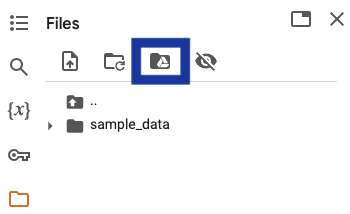

2. Click "Connect to Google Drive" and go through the authentication prompts:

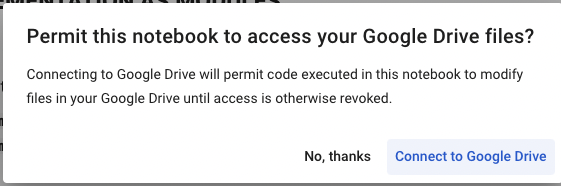

3. Access your Google Drive via the "drive" link in the Files browser:

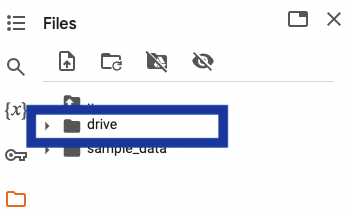

## Step 2: Create Python files in Google Drive

1. Navigate to the folder you want to create Python files in;
2. Click on the three dots to the right hand side of the folder:

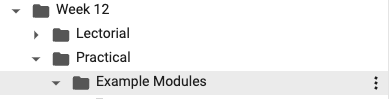

3. Click on "New file" and give it a name ending in ".py"

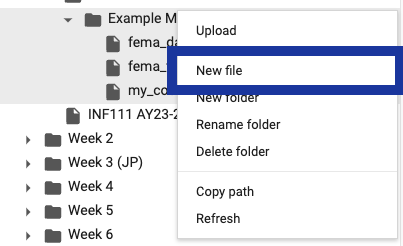

4. Double-click on the file to open an editor window in Colab (to the right-hand side of this notebook)

## Step 3 (**FOR COLAB ONLY**): Add the Google Drive folder to the Path

Because Colab runs Python on its own virtual instance, you will need to tell it where to find the Python files you have created.

**If you are running Python on your machine directly, it will already have access to anything in the same folder that you are running Python from.**

1. Click on the three dots next to your folder again and select "Copy path"

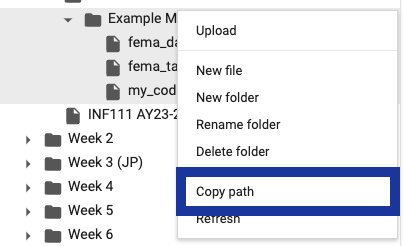

2. This will copy the path to your Google Drive folder onto the clipboard. Paste this in for the `my_path` variable below:

In [ ]:
my_path = '/content/drive/MyDrive/Teaching/AY2023-2024/INF111/Week 12/Practical/Working with Modules/'

import sys
sys.path.append(my_path)

## Step 3: Load the modules and use the logic!

The code block below includes the third portion of the original implementation, the **script execution**.

**NOTE** that as this is a _specific set of commands_ we are executing for _this specific analysis_, I did not put it into its own `.py` module file.

This is the kind of thing Colab/Jupyter notebooks are very good for--**recording the specific commands you execute in an analysis, with the re-usable logic implemented in separate modules.**

In [ ]:
# We can load in the fema_task_logic.py file here using the same import
# command as for pandas, numpy, or sqlite3
import fema_task_logic

fname = 'Zip_level_risk_FEMA_FSF_v1.3.csv'

# And now we can access the functions implemented in fema_task_logic directly
data = fema_task_logic.loadCSV(fname, key='zipcode')

one_digit = fema_task_logic.combineAtZipLevel(data, 1)
for (digit, row) in sorted(one_digit.items()):
  print(digit, row.data['count_property'], row.data['pct_fema_sfha'])

three_digit = fema_task_logic.combineAtZipLevel(data, 3)
for (digit, row) in sorted(three_digit.items()):
  print(digit, row.data['count_property'], row.data['pct_fema_sfha'])